### 1. importing needed packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 2. Loading the data

In [2]:
# loading all sheets
url = "E-commerce_data.xlsx"
customers = pd.read_excel(url, sheet_name="customers")
genders = pd.read_excel(url, sheet_name="genders")
cities = pd.read_excel(url, sheet_name="cities")
transactions = pd.read_excel(url, sheet_name="transactions")
branches = pd.read_excel(url, sheet_name="branches")
merchants = pd.read_excel(url, sheet_name="merchants")

# Merge gender and city data into the customers table
customers = customers.merge(genders, on='gender_id', how='left')
customers = customers.merge(cities, on='city_id', how='left')

# Merge transaction data into customers
transactions = transactions.merge(customers[['customer_id', 'gender_name', 'city_name']], on='customer_id', how='left')

# Merge branch and merchant data into transactions
transactions = transactions.merge(branches, on='branch_id', how='left')
transactions = transactions.merge(merchants, on='merchant_id', how='left')

In [3]:
customers.head()

,customer_id,join_date,city_id,gender_id,gender_name,city_name
0,1,2022-01-08,7,1,Male,Mansoura
1,2,2023-05-02,20,2,Female,Sohag
2,3,2023-05-14,15,1,Male,Aswan
3,4,2022-11-25,11,2,Female,Ismailia
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra


In [4]:
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,gender_name,city_name,merchant_id,merchant_name
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,Female,Aswan,7,Berry-Anderson
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,Female,Damietta,9,"Campbell, Shaffer and Martinez"
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,Male,Alexandria,7,Berry-Anderson
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,Female,Aswan,18,Lewis LLC
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,Male,Damietta,15,Butler-Gomez


### Feature Engineering

In [5]:
# Creating new feature : Coupon usage frequency per customer
transaction_features = transactions.groupby('customer_id').agg({
    'transaction_id': 'count',
    'transaction_status': lambda x: sum(x == 'burnt') / len(x)  # Burn rate
}).reset_index()

transaction_features.columns = ['customer_id', 'transaction_count', 'burn_rate']

# Merge transaction features back to the customer table
customer_data = customers.merge(transaction_features, on='customer_id', how='left')

# Fill missing values
customer_data['transaction_count'] = customer_data['transaction_count'].fillna(0)
customer_data['burn_rate'] = customer_data['burn_rate'].fillna(0)


In [7]:
# Select relevant features for clustering
X = customer_data[['transaction_count', 'burn_rate', 'gender_name', 'city_name']]

# Convert categorical variables to numeric
X = pd.get_dummies(X, columns=['gender_name', 'city_name'], drop_first=True)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

customer_data['Cluster'].value_counts()

c:\Users\samam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Cluster
4    766
1     67
3     57
0     55
2     55
Name: count, dtype: int64

In [8]:
# Checking Silhouette score
silhouette_avg = silhouette_score(X_scaled, customer_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

# Inertia (sum of squared distances to the nearest cluster center)
f'Inertia: {kmeans.inertia_}'


Silhouette Score: 0.1629990743164807


'Inertia: 16759.220080412797'

In [10]:
# Group by cluster and summarize customer behavior
cluster_summary = customer_data.groupby('Cluster').agg({
    'transaction_count': 'mean',
    'burn_rate': 'mean',
    'customer_id': 'count'  # Number of customers in each cluster
}).reset_index()

cluster_summary

,Cluster,transaction_count,burn_rate,customer_id
0,0,4.781818,0.0,55
1,1,5.029851,0.0,67
2,2,4.781818,0.0,55
3,3,4.614035,0.0,57
4,4,5.057441,0.0,766


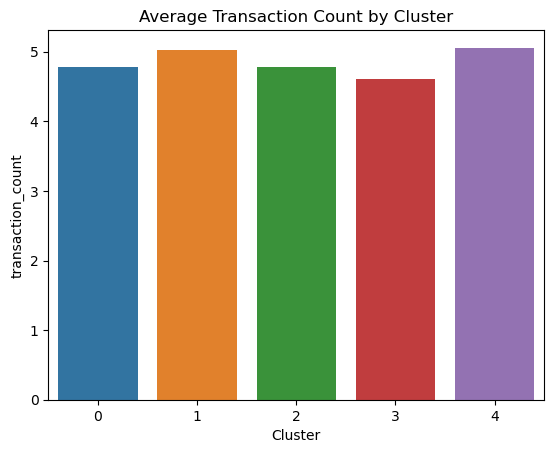

In [11]:
# Visualize the segments
sns.barplot(x='Cluster', y='transaction_count', data=cluster_summary)
plt.title('Average Transaction Count by Cluster')
plt.show()